## Importing Dataset Cleaned by Matchms and Lookups

In [1]:
import os
import sys
import gensim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\Users\\User\\Data'
sys.path.insert(0, ROOT)

from matchms.importing import load_from_json

filename = os.path.join(path_data,'gnps_positive_ionmode_cleaned_by_matchms_and_lookups.json')
spectrums = load_from_json(filename)

print("number of spectra:", len(spectrums))

number of spectra: 112956


## Plotting peaks per spectrum

Text(0, 0.5, 'number of spectra in respective bin')

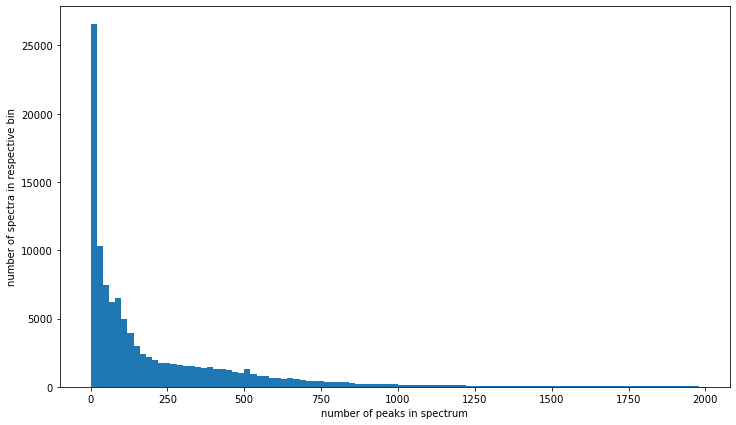

In [2]:
number_of_peaks = [len(spec.peaks) for spec in spectrums]

plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

## Post-Process

Preparing data for cosine similarity scoring. Done by:

- normalize peaks (maximum intensity to 1)
- remove peaks outside [0, 1000] m/z window
- remove spectra with < 10 peaks
- remove peaks with intensities < 0.01 of maximum intensity.

In [3]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

def post_process(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = select_by_relative_intensity(s, intensity_from=0.01, intensity_to=1.0)
    return s

# apply filters to the data
spectrums = [post_process(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums = [s for s in spectrums if s is not None]

print("{} remaining spectra.".format(len(spectrums)))

95320 remaining spectra.


Text(0, 0.5, 'number of spectra in respective bin')

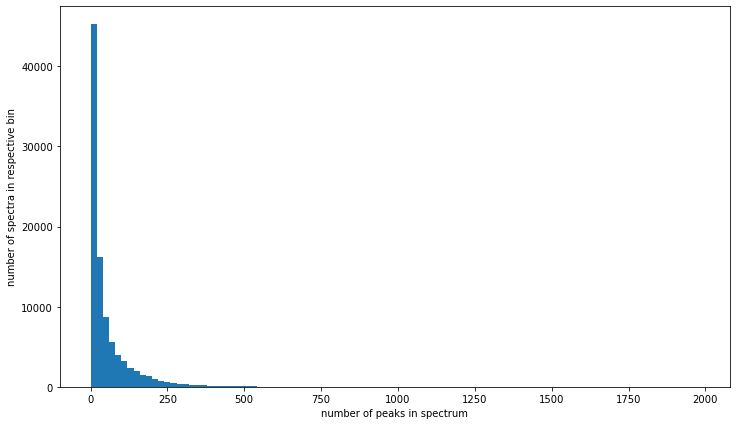

In [4]:
number_of_peaks = [len(spec.peaks) for spec in spectrums]

plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

In [5]:
np.max(number_of_peaks)

42049

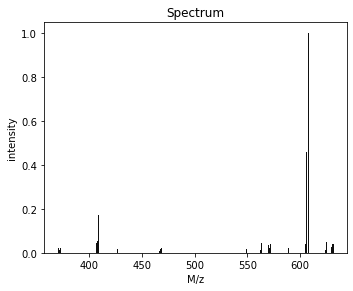

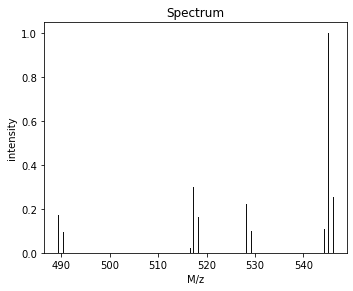

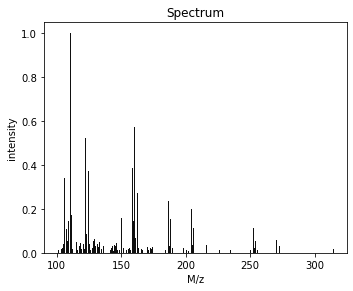

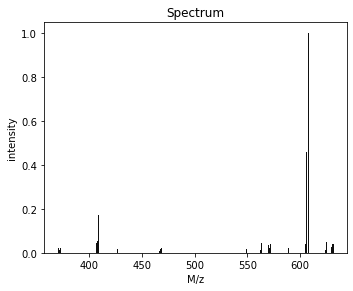

In [45]:

spectrums[3].plot()
spectrums[4].plot()
spectrums[5].plot()

## Naive Decoy Approach

For the naive decoy spectral library, we use all possible fragment ions from the reference library of spectra and then randomly add these ions to the decoy spectra library, until each decoy spectrum reaches the desired number of fragment ions that mimics the corresponding library spectrum. This method is presented as a baseline evaluation of the other, more intricate methods.

1. Determine if there is a parent peak in target spectrum
2. If parent peak = false, move to next spectrum in target spectra list.
3. If parent peak = true, add to new decoy object:
   - The parent peak is added to the array of peaks in the new decoy object
4. Find number of peaks in target spectrum (the length of the list containing all peaks)
5. Select that number of spectra randomly from the list of all spectra in target list
6. Select from each of those individually a random peak
7. Add those peaks to the list of peaks in the decoy spectrum, until number peaks in decoy spectrum = number of peaks in target spectrum. 
8. Add new complete decoy spectrum to decoy spectra library (naive)



## Spectrum-based Decoy Approach

The second method is similar to the naive method, as we create the decoy spectral library through choosing fragment ions that co-appear in the spectra from the target spectral library (Fig. 1c): In this spectrum-based approach, we start with an empty set of fragment ion candidates. First, the precursor fragment ion of the target spectrum is added to the decoy spectrum. For each fragment ion added to the decoy spectrum, we choose all spectra from the target spectral library which contain this fragment ion, within a mass range of 5 p.p.m. From these spectra, we uniformly draw (all fragment ions have the same probability to be drawn) five fragment ions that are added to the fragment ion candidate set; we use all fragment ions in case there are fewer than five. We draw a fragment ion from the fragment ion candidate set and add it to the decoy spectrum, then proceed as described above until we reach the desired number of fragment ions that mimics the corresponding library spectrum. The two-step process of first drawing candidates, then drawing the actual decoy spectrum was introduced to better mimic fragmentation cascades and dependencies between fragments. Furthermore, it prevents that fragment-rich spectra dominate the process. Out of the five added candidate fragment ions, between zero and five end up in the final decoy spectrum. Fragment ions with mass close (5 p.p.m.) to a previously added fragment ion mass, or masses above the precursor fragment ion mass are discarded. If the precursor ion is absent from the MS/MS spectrum, we use the selected ion mass to find matching compound masses. 

1. Determine if there is a parent peak in target spectrum
2. If parent peak = false, move to next spectrum in target spectra list.
3. If parent peak = true, add to new decoy spectrum object:
   - The parent peak is added to the array of peaks in the new decoy object
4. Create a list of all spectra from the target list that contain the same fragment ion (search all peaks for a mass identical to or within a close range of the parent peak - mass range of 5 p.p.m)
5. Create an empty list of candidate fragment ions that will be drawn from
6. Draw 5 fragment ions from each of the spectra on list created at step 4 and add those to candidate list created at step 5
7. Randomly draw a fragment ion from the candidate list:
   - If its mass < precursor peak of target spectrum AND is not within 5 p.p.m of any other peak, then the peak is added to the      decoy spectrum's list of peaks.
   - If it fails either of the conditions above, it is discarded and another candidate fragment is drawn.
8. Repeat step 7 until number peaks in decoy spectrum = number of peaks in target spectrum. 
9. Add completed decoy to decoy spectral library. 
